In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.animation import FuncAnimation
from scipy.linalg import block_diag
from scipy.stats import multivariate_normal
from scipy.optimize import minimize
from collections import defaultdict
from scipy.stats import chi2
import seaborn as sns

In [2]:
file_path = './Synched_Data_GR0_22_DEN_MAXZ1_25/NEWDATA/'
file_date = ['101922', '102122', '111422', '111622', '120522', '120722', 
                '013023', '020123', '031323', '031523', '041723', '041923', '061523']
date = file_date[0]

file_name = f'DAYUBIGR_{date}_GR0_22_DEN_032825_V2392628911.CSV'
full_path = file_path + file_name

raw_data = pd.read_csv(full_path, header=None, names=['SUBJECTID', 'TIME', 'X', 'Y', 'Z'])
clear_data = raw_data.reset_index(drop=True)
clear_data = clear_data[(clear_data["X"] <= 15) & (clear_data["Y"] <= 9) & 
                        (clear_data["X"] >= 0) & (clear_data["Y"] >= 0)].copy()
target_subject_base = "DS_STARFISH_2223_27"
subject_data = clear_data[clear_data['SUBJECTID'].str.startswith(target_subject_base)].copy()
subject_data['TIME'] = pd.to_datetime(subject_data['TIME'])
t0 = subject_data['TIME'].min()
subject_data['timestamp'] = (subject_data['TIME'] - t0).dt.total_seconds()

subject_data['side'] = subject_data['SUBJECTID'].str.extract(r'(\d+[LR])$')[0].str[-1].map({'L': 'left', 'R': 'right'})
subject_data['timestamp_rounded'] = subject_data['timestamp'].round(3)

grouped = subject_data.groupby('timestamp_rounded')
real_data = []

for ts, group in grouped:
    entry = {'timestamp': ts}
    left = group[group['side'] == 'left']
    right = group[group['side'] == 'right']
    
    if not left.empty:
        left_xy = left[['X', 'Y']].iloc[0].to_numpy()
        entry['left'] = left_xy
    if not right.empty:
        right_xy = right[['X', 'Y']].iloc[0].to_numpy()
        entry['right'] = right_xy
    
    if 'left' in entry and 'right' in entry:
        entry['observed'] = 'both'
        entry['obs'] = np.concatenate([entry['left'], entry['right']])
    elif 'left' in entry:
        entry['observed'] = 'left'
        entry['obs'] = entry['left']
    elif 'right' in entry:
        entry['observed'] = 'right'
        entry['obs'] = entry['right']
    else:
        entry['observed'] = 'none'
        entry['obs'] = np.array([])

    real_data.append(entry)

## Visualize the raw trajectory with paired data

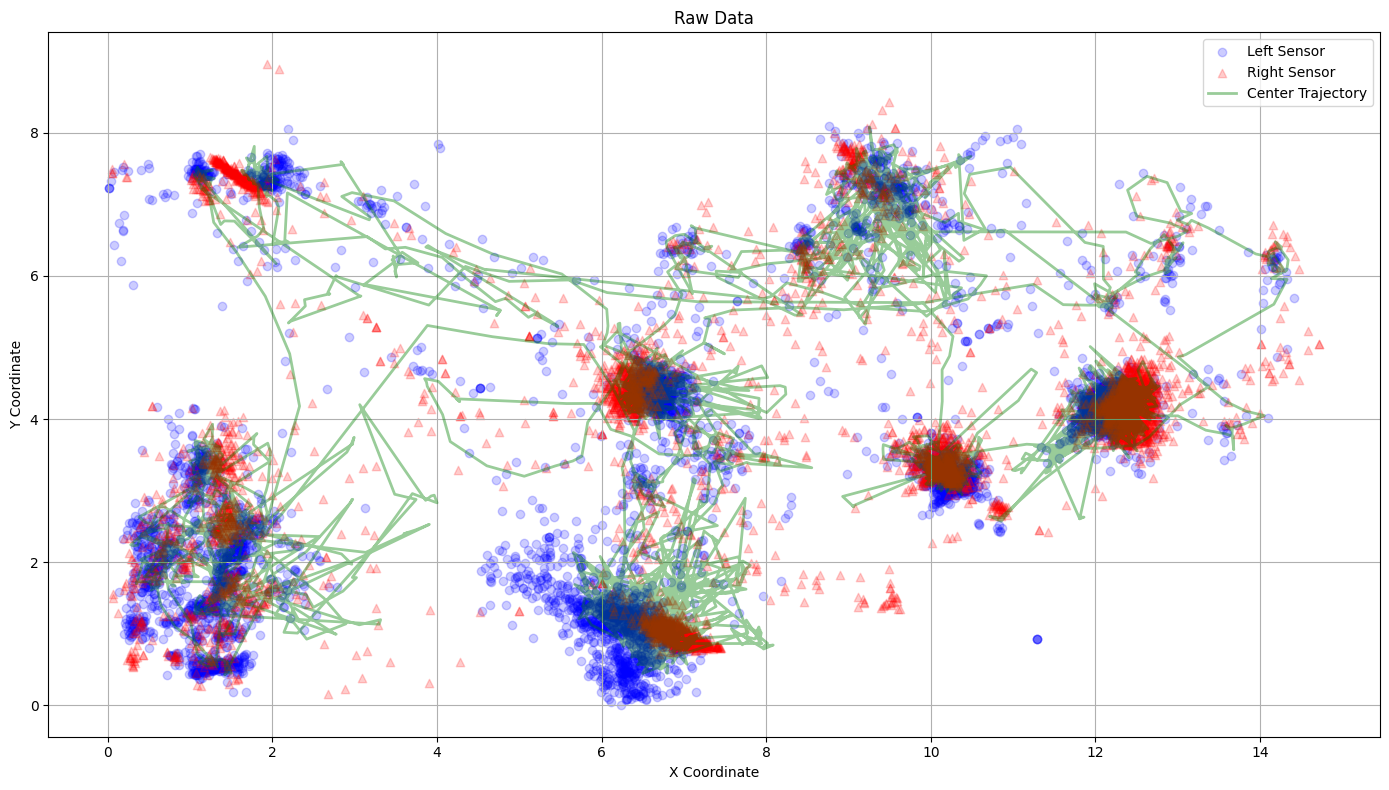

In [37]:
# print(f"Total entries: {len(data)}")
left_data = subject_data[subject_data['side'] == 'left'].copy()
right_data = subject_data[subject_data['side'] == 'right'].copy()

paired_data = []
threshold = 1.0  # seconds

for i, left_row in left_data.iterrows():
    time_diff = (right_data['timestamp'] - left_row['timestamp']).abs()
    min_idx = time_diff.idxmin()
    if time_diff[min_idx] <= threshold:
        right_row = right_data.loc[min_idx]
        center_x = (left_row['X'] + right_row['X']) / 2
        center_y = (left_row['Y'] + right_row['Y']) / 2
        avg_time = (left_row['timestamp'] + right_row['timestamp']) / 2
        paired_data.append((avg_time, center_x, center_y))

paired_df = pd.DataFrame(paired_data, columns=['timestamp', 'center_X', 'center_Y'])

plt.figure(figsize=(14, 8))
plt.scatter(left_data['X'], left_data['Y'], label='Left Sensor', color='b', marker='o', alpha=0.2)
plt.scatter(right_data['X'], right_data['Y'], label='Right Sensor', color='r', marker='^', alpha=0.2)
plt.plot(paired_df['center_X'], paired_df['center_Y'], color='g', linewidth=2, alpha=0.4, label='Center Trajectory')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend()
plt.title('Raw Data')
plt.grid(True)
plt.tight_layout()
plt.show()

## Building the model

In [3]:
DT_VIRT = 0.5  # Virtual time step interval
SIGMA_MIN = 0.000001
SIGMA_MAX = 10

In [36]:
def track_parameters(params):
    global param_history, iteration_count
    
    sigma_vx, sigma_vy, sigma_omega, sigma_obs, d = params
    
    param_history['iteration'].append(iteration_count)
    param_history['sigma_vx'].append(sigma_vx)
    param_history['sigma_vy'].append(sigma_vy)
    param_history['sigma_omega'].append(sigma_omega)
    param_history['sigma_obs'].append(sigma_obs)
    param_history['d'].append(d)
    
    iteration_count += 1

In [4]:
def state_transition(s_t, delta_t):
    x, y, theta, vx, vy, omega = s_t
    return np.array([
        x + vx * delta_t,
        y + vy * delta_t,
        theta + omega * delta_t,
        vx,
        vy,
        omega
    ])

def jacobian_F(delta_t):
    return np.array([
        [1, 0, 0, delta_t, 0, 0],
        [0, 1, 0, 0, delta_t, 0],
        [0, 0, 1, 0, 0, delta_t],
        [0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1]
    ])

def h(s_t, observed_sensors, d):
    x, y, theta = s_t[0], s_t[1], s_t[2]
    if observed_sensors == 'both':
        # Lx, Ly, Rx, Ry
        return np.array([
            x - d * np.sin(theta),
            y + d * np.cos(theta),
            x + d * np.sin(theta),
            y - d * np.cos(theta)
        ])
    elif observed_sensors == 'left':
        return np.array([x - d * np.sin(theta), y + d * np.cos(theta)])
    elif observed_sensors == 'right':
        return np.array([x + d * np.sin(theta), y - d * np.cos(theta)])
    else:  # 'none'
        return np.array([])

def jacobian_h(s_t, observed_sensors, d):
    theta = s_t[2]
    if observed_sensors == 'both':
        return np.array([
            [1, 0, -d * np.cos(theta), 0, 0, 0],
            [0, 1, -d * np.sin(theta), 0, 0, 0],
            [1, 0, d * np.cos(theta), 0, 0, 0],
            [0, 1, d * np.sin(theta), 0, 0, 0]
        ])
    elif observed_sensors == 'left':
        return np.array([
            [1, 0, -d * np.cos(theta), 0, 0, 0],
            [0, 1, -d * np.sin(theta), 0, 0, 0]
        ])
    elif observed_sensors == 'right':
        return np.array([
            [1, 0, d * np.cos(theta), 0, 0, 0],
            [0, 1, d * np.sin(theta), 0, 0, 0]
        ])
    else:  # 'none'
        return np.zeros((0, 6))

In [5]:
def ekf_forward(data, timestamps, virtual_timestamps, params):
    sigma_vx, sigma_vy, sigma_omega, sigma_obs, d = params
    master_timestamps = sorted(set(timestamps + virtual_timestamps))
    T = len(master_timestamps)
    s_hat = [np.zeros(6)] * T  # Predicted states
    P = [np.zeros((6, 6))] * T  # Predicted covariances
    s_filt = [np.zeros(6)] * T  # Filtered states
    P_filt = [np.zeros((6, 6))] * T  # Filtered covariances
    neg_log_likelihood = 0.0  # Initialize negative log-likelihood for minimization

    # Initialize state and covariance
    s_hat[0] = np.zeros(6)  # [x, y, theta, vx, vy, omega] = 0
    # Try to initialize with first observation if available
    for entry in data[:10]:
        if entry['observed'] != 'none':
            if entry['observed'] == 'left':
                s_hat[0][:2] = entry['left']
                break
            elif entry['observed'] == 'right':
                s_hat[0][:2] = entry['right']
                break
            elif entry['observed'] == 'both':
                s_hat[0][:2] = (entry['left'] + entry['right']) / 2
                break
                
    P[0] = np.diag([1, 1, 1, 1, 1, 0.1])  # Initial uncertainty
    s_filt[0] = s_hat[0]  # Initialize filtered state with predicted state
    P_filt[0] = P[0]      # Initialize filtered covariance with predicted covariance

    for k in range(T - 1):
        t_k = master_timestamps[k]
        t_k1 = master_timestamps[k + 1]
        delta_t = t_k1 - t_k

        # Prediction step
        s_hat[k + 1] = state_transition(s_filt[k], delta_t)
        F_k = jacobian_F(delta_t)
        Q_k = block_diag(0, 0, 0, sigma_vx**2 * delta_t, sigma_vy**2 * delta_t, sigma_omega**2 * delta_t)
        P[k + 1] = F_k @ P_filt[k] @ F_k.T + Q_k

        # Update step (only for actual timestamps with observations)
        if t_k1 in timestamps:
            idx = timestamps.index(t_k1)
            observed_sensors = data[idx]['observed']
            if observed_sensors != 'none':
                H_k1 = jacobian_h(s_hat[k + 1], observed_sensors, d)
                z_pred = h(s_hat[k + 1], observed_sensors, d)
                z_k1 = data[idx]['obs']
                m_t = len(z_k1)
                R = sigma_obs**2 * np.eye(m_t)
                S_k1 = H_k1 @ P[k + 1] @ H_k1.T + R
                
                # Ensure S_k1 is positive definite for numerical stability
                S_k1 = (S_k1 + S_k1.T) / 2  # Make symmetric
                
                try:
                    # Calculate innovation and its contribution to negative log likelihood
                    innovation = z_k1 - z_pred
                    sign, logdet = np.linalg.slogdet(S_k1)
                    if sign > 0:  # Check if determinant is positive
                        # Use log determinant formula for numerical stability
                        neg_log_likelihood += 0.5 * (m_t * np.log(2 * np.pi) + logdet + 
                                              innovation @ np.linalg.inv(S_k1) @ innovation)
                    
                    # Kalman gain and state update
                    K_k1 = P[k + 1] @ H_k1.T @ np.linalg.inv(S_k1)
                    s_filt[k + 1] = s_hat[k + 1] + K_k1 @ innovation
                    P_filt[k + 1] = (np.eye(6) - K_k1 @ H_k1) @ P[k + 1]
                except np.linalg.LinAlgError:
                    # If matrix inversion fails, skip the update
                    s_filt[k + 1] = s_hat[k + 1]
                    P_filt[k + 1] = P[k + 1]
            else:
                s_filt[k + 1] = s_hat[k + 1]
                P_filt[k + 1] = P[k + 1]
        else:
            s_filt[k + 1] = s_hat[k + 1]
            P_filt[k + 1] = P[k + 1]
            
    return s_filt, P_filt, s_hat, P, neg_log_likelihood

In [66]:
def smoother(s_filt, P_filt, s_hat, P, timestamps, virtual_timestamps):
    master_timestamps = sorted(set(timestamps + virtual_timestamps))
    T = len(master_timestamps)
    s_smooth = [np.zeros(6)] * T
    P_smooth = [np.zeros((6, 6))] * T
    s_smooth[-1] = s_filt[-1]
    P_smooth[-1] = P_filt[-1]

    for k in range(T - 2, -1, -1):
        t_k = master_timestamps[k]
        t_k1 = master_timestamps[k + 1]
        delta_t = t_k1 - t_k
        F_k = jacobian_F(delta_t)
        
        # Prevent numerical issues with the inversion
        try:
            C_k = P_filt[k] @ F_k.T @ np.linalg.inv(P[k + 1])
            s_smooth[k] = s_filt[k] + C_k @ (s_smooth[k + 1] - s_hat[k + 1])
            P_smooth[k] = P_filt[k] + C_k @ (P_smooth[k + 1] - P[k + 1]) @ C_k.T
        except np.linalg.LinAlgError:
            # Fall back to filtered estimates if inversion fails
            s_smooth[k] = s_filt[k]
            P_smooth[k] = P_filt[k]

    return s_smooth, P_smooth

def optimize_parameters(data, timestamps, virtual_timestamps, initial_params=None):
    if initial_params is None:
        initial_params = [0.5, 0.5, 0.1, 0.5, 0.23]  # Initial guess
    
    # Set bounds for parameters to ensure stability
    bounds = [
        (SIGMA_MIN, SIGMA_MAX),  # sigma_vx
        (SIGMA_MIN, SIGMA_MAX),  # sigma_vy
        (SIGMA_MIN, SIGMA_MAX),  # sigma_omega
        (SIGMA_MIN, SIGMA_MAX),  # sigma_obs
        (0.01, 1.0)              # d (distance between sensors)
    ]
    
    # Define objective function inline
    def objective(params):
        try:
            _, _, _, _, neg_log_likelihood = ekf_forward(data, timestamps, virtual_timestamps, params)
            return neg_log_likelihood
        except Exception as e:
            print(f"Error in objective function: {e}")
            return 1e10  # Return a large value if there's an error
    
    result = minimize(
        objective,
        initial_params,
        method='L-BFGS-B',
        bounds=bounds,
        options={'disp': True, 'maxiter': 50}  # Limit iterations for faster convergence
    )
    
    return result.x

In [ ]:
def process_trajectory(data, max_data_points):
    data_subset = data[:max_data_points]
    timestamps = [entry['timestamp'] for entry in data_subset]
    virtual_timestamps = np.arange(min(timestamps), max(timestamps), DT_VIRT).tolist()
    
    optimized_params = optimize_parameters(data_subset, timestamps, virtual_timestamps)
    print("Optimized parameters (sigma_vx, sigma_vy, sigma_omega, sigma_obs, d):", optimized_params)
    
    s_filt, P_filt, s_hat, P, neg_log_likelihood = ekf_forward(data_subset, timestamps, virtual_timestamps, optimized_params)
    
    s_smooth, P_smooth = smoother(s_filt, P_filt, s_hat, P, timestamps, virtual_timestamps)
    
    print("Negative log-likelihood:", neg_log_likelihood)
    
    return s_smooth, P_smooth, optimized_params, virtual_timestamps

In [24]:
def visualize_results(data, s_smooth, virtual_timestamps, master_timestamps):
    plt.figure(figsize=(12, 8))
    
    # raw observations
    left_x, left_y = [], []
    right_x, right_y = [], []
    
    for entry in data:
        if 'left' in entry:
            left_x.append(entry['left'][0])
            left_y.append(entry['left'][1])
        if 'right' in entry:
            right_x.append(entry['right'][0])
            right_y.append(entry['right'][1])
    
    plt.scatter(left_x, left_y, color='blue', alpha=0.3, label='Left Sensor')
    plt.scatter(right_x, right_y, color='red', alpha=0.3, label='Right Sensor')
    
    # smoothed trajectory
    plt.plot([s[0] for s in s_smooth], [s[1] for s in s_smooth], 'g-', alpha=0.7, linewidth=2, label='Smoothed Trajectory')
    plt.grid(True)
    
    # arrows to indicate orientation
    # num_arrows = 20
    # indices = np.linspace(0, len(s_smooth)-1, num_arrows).astype(int)
    # for i in indices:
    #     s = s_smooth[i]
    #     plt.arrow(s[0], s[1], 0.2*np.cos(s[2]), 0.2*np.sin(s[2]), 
    #               head_width=0.1, head_length=0.1, fc='k', ec='k')
    
    # plt.xlabel('X Position')
    # plt.ylabel('Y Position')
    # plt.title('Trajectory Reconstruction')
    # plt.legend()
    # plt.grid(True)
    # plt.axis('equal')  # Equal aspect ratio
    # plt.show()
    
    # state variables over time
    # fig, axs = plt.subplots(3, 2, figsize=(15, 10))
    # state_names = ['Orientation', 'X Velocity', 'Y Velocity', 'Angular Velocity']
    
    # for i in range(6):
    #     row, col = i // 2, i % 2
    #     axs[row, col].plot([master_timestamps[j] for j in range(len(s_smooth))], 
    #                       [s[i] for s in s_smooth], 'g-', linewidth=2)
    #     axs[row, col].set_title(state_names[i])
    #     axs[row, col].set_xlabel('Time (s)')
    #     axs[row, col].grid(True)
    
    plt.tight_layout()
    plt.show()

## Test with first 3000 data points

Optimized parameters (sigma_vx, sigma_vy, sigma_omega, sigma_obs, d): [0.49943293 0.50034073 0.09195618 0.42774451 0.24155054]
Negative log-likelihood: 5945.851584048384


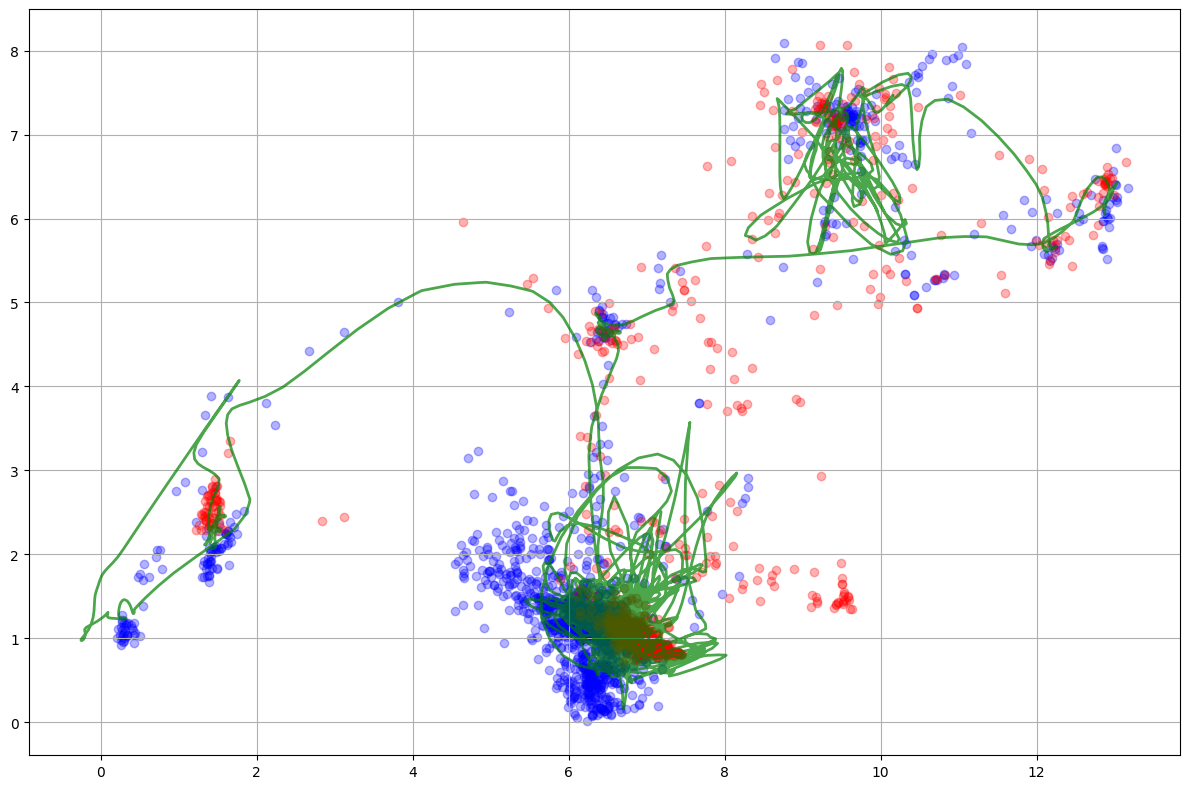

In [67]:
if __name__ == "__main__":
    max_data_points = 3000

    s_smooth, P_smooth, optimized_params, virtual_timestamps = process_trajectory(real_data, max_data_points)
    
    timestamps = [entry['timestamp'] for entry in real_data[:max_data_points]]
    master_timestamps = sorted(set(timestamps + virtual_timestamps))
    
    visualize_results(real_data[:max_data_points], s_smooth, virtual_timestamps, master_timestamps)

## Test the model with generated data

In [115]:
def generate_synthetic_data(num_points=1000, d=0.23, noise_level=0.2, asynchronous=True, circle_radius=3.0, center_x=5.0, center_y=4.0):
    generate_data = []
    timestamps = []
    total_time = 600
    
    base_timestamps = np.linspace(0, total_time, num_points)
    
    timestamps = [0]
    # do random time jumps
    for i in range(1, len(base_timestamps)):
        interval = base_timestamps[i] - base_timestamps[i-1]
        jittered_interval = interval * np.random.uniform(0.8, 1.2)
        timestamps.append(timestamps[-1] + jittered_interval)
    
    # Generate varying angular velocity (speed changes)
    base_angular_vel = 2 * np.pi / total_time  # One full circle in total_time
    
    # Create varying speed pattern (speeds up and slows down)
    speed_factors = 1.0 + 0.1 * np.sin(np.linspace(0, 4*np.pi, num_points))
    angular_velocities = base_angular_vel * speed_factors
    
    true_states = []
    current_angle = 0
    
    for i in range(num_points):
        # Current angle based on changing angular velocity
        if i > 0:
            dt = timestamps[i] - timestamps[i-1]
            angular_vel = angular_velocities[i-1]
            current_angle += angular_vel * dt
        
        x = center_x + circle_radius * np.cos(current_angle)
        y = center_y + circle_radius * np.sin(current_angle)
        # x = center_x + 0.5
        # y = center_y + 0.5
        
        theta = current_angle + np.pi/2
        
        vx = -circle_radius * angular_velocities[i] * np.sin(current_angle)
        vy = circle_radius * angular_velocities[i] * np.cos(current_angle)
        
        true_states.append([x, y, theta, vx, vy, angular_velocities[i]])
    
    # Generate sensor observations with noise and asynchronicity
    for i, (timestamp, state) in enumerate(zip(timestamps, true_states)):
        x, y, theta, vx, vy, omega = state
        
        # Calculate true sensor positions
        left_x_true = x + d * np.sin(theta)
        left_y_true = y + d * np.cos(theta)
        right_x_true = x + d * np.sin(theta)
        right_y_true = y + d * np.cos(theta)
        
        # noise
        left_x = left_x_true + np.random.normal(0, noise_level)
        left_y = left_y_true + np.random.normal(0, noise_level)
        right_x = right_x_true + np.random.normal(0, noise_level)
        right_y = right_y_true + np.random.normal(0, noise_level)
        
        # Decide which sensors to include based on asynchronicity
        entry = {'timestamp': timestamp}
        if asynchronous:
            sensor_case = np.random.choice(['left', 'right'], p=[0.45, 0.55])
            if sensor_case == 'left' :
                entry['left'] = np.array([left_x, left_y])
            elif sensor_case == 'right':
                entry['right'] = np.array([right_x, right_y])
        
        # Set observed field
        if 'left' in entry and 'right' in entry:
            entry['observed'] = 'both'
            entry['obs'] = np.concatenate([entry['left'], entry['right']])
        elif 'left' in entry:
            entry['observed'] = 'left'
            entry['obs'] = entry['left']
        elif 'right' in entry:
            entry['observed'] = 'right'
            entry['obs'] = entry['right']
        else:
            entry['observed'] = 'none'
            entry['obs'] = np.array([])
        
        generate_data.append(entry)
    
    # Store ground truth for evaluation
    for i, state in enumerate(true_states):
        generate_data[i]['true_state'] = np.array(state)
    
    return generate_data

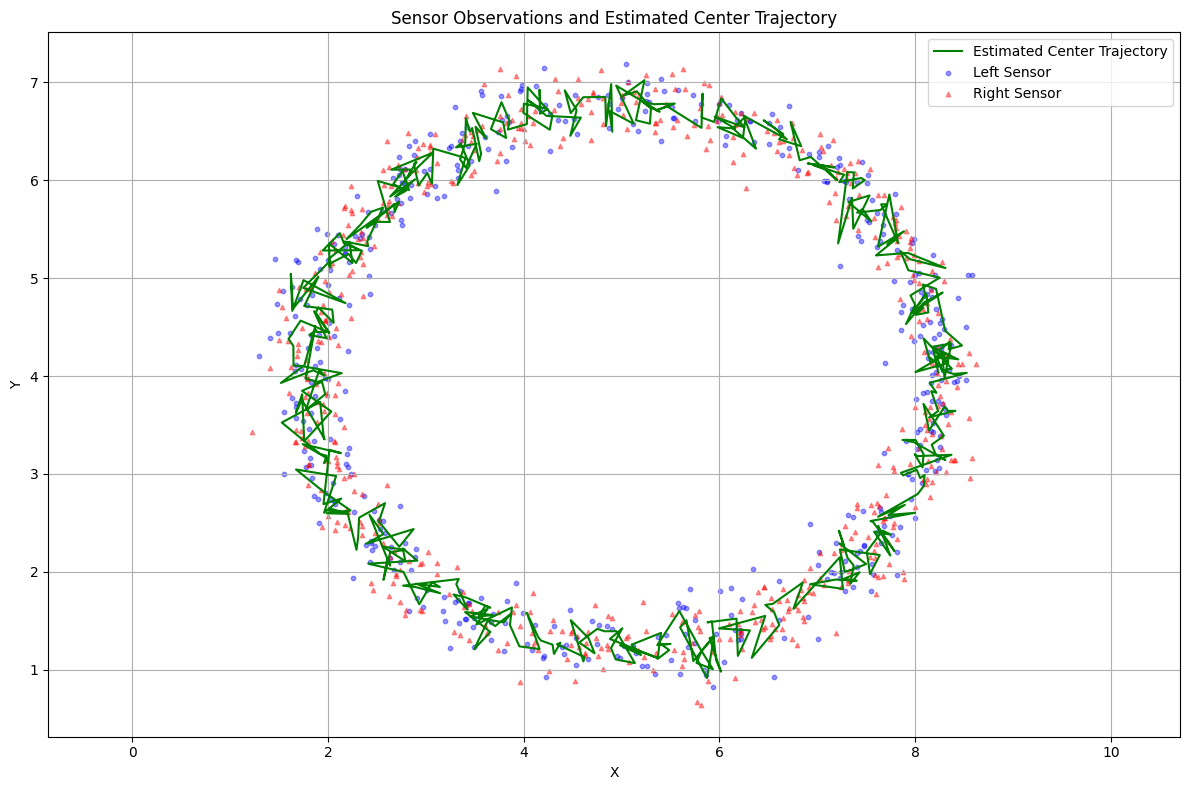

In [125]:
test_data = generate_synthetic_data()

left_data = []
right_data = []

for entry in test_data:
    timestamp = entry['timestamp']
    if 'left' in entry:
        left_data.append((timestamp, entry['left']))
    if 'right' in entry:
        right_data.append((timestamp, entry['right']))

left_times, left_coords = zip(*left_data)
right_times, right_coords = zip(*right_data)

left_times = np.array(left_times)
left_coords = np.array(left_coords)
right_times = np.array(right_times)
right_coords = np.array(right_coords)

center_coords = []
paired_times = []

for l_time, l_coord in zip(left_times, left_coords):
    # Find the index of the right sensor time closest to this left time
    idx = np.argmin(np.abs(right_times - l_time))
    r_coord = right_coords[idx]
    
    # Average the two coordinates to get center
    center = (l_coord + r_coord) / 2.0
    center_coords.append(center)
    
    # Save the average time for plotting (or just use left time)
    paired_times.append((l_time + right_times[idx]) / 2)

center_coords = np.array(center_coords)
paired_times = np.array(paired_times)

plt.figure(figsize=(12, 8))

plt.plot(center_coords[:, 0], center_coords[:, 1], linestyle='-', color='g', label='Estimated Center Trajectory')
plt.scatter(left_coords[:, 0], left_coords[:, 1], color='b', alpha=0.4, s=10, marker='o', label='Left Sensor')
plt.scatter(right_coords[:, 0], right_coords[:, 1], color='r', alpha=0.4, s=10, marker='^', label='Right Sensor')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Sensor Observations and Estimated Center Trajectory')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.tight_layout()
plt.show()



Optimized parameters (sigma_vx, sigma_vy, sigma_omega, sigma_obs, d): [0.50475366 0.50571627 0.07262749 0.37029011 0.21836897]
Negative log-likelihood: 1385.793679737694


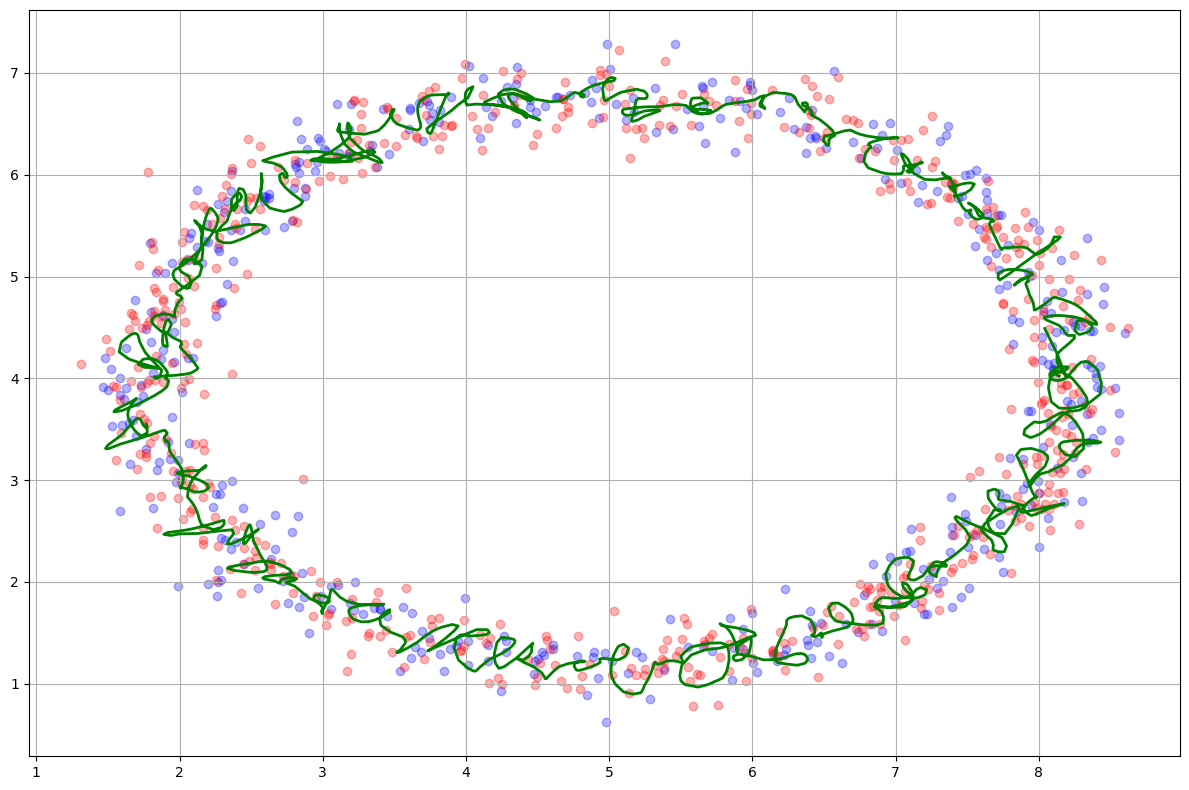

In [123]:
if __name__ == "__main__":

    synthetic_data = test_data
    
    # Process the synthetic data
    s_smooth, P_smooth, optimized_params, virtual_timestamps = process_trajectory(synthetic_data)
    
    timestamps = [entry['timestamp'] for entry in synthetic_data]
    master_timestamps = sorted(set(timestamps + virtual_timestamps))
    
    # Visualize the results
    visualize_results(synthetic_data, s_smooth, virtual_timestamps, master_timestamps)

## Test the model with time segments


Time Segments Information:
Segment 1: 0.00s - 2273.57s | Duration: 2273.57s | Points: 3671
Segment 2: 2353.03s - 2625.59s | Duration: 272.56s | Points: 390
Segment 3: 2653.03s - 2688.04s | Duration: 35.01s | Points: 38
Segment 4: 2705.02s - 2713.03s | Duration: 8.01s | Points: 9
Segment 5: 2774.60s - 2799.03s | Duration: 24.43s | Points: 28
Segment 6: 2815.60s - 2836.04s | Duration: 20.43s | Points: 16
Segment 7: 2862.59s - 2865.59s | Duration: 3.00s | Points: 4
Segment 8: 2893.59s - 2895.59s | Duration: 2.00s | Points: 3
Segment 9: 2911.03s - 2923.03s | Duration: 12.00s | Points: 12
Segment 10: 2943.04s - 3508.60s | Duration: 565.56s | Points: 651
Segment 11: 3524.60s - 4374.62s | Duration: 850.02s | Points: 1604
Segment 12: 4395.61s - 4421.62s | Duration: 26.01s | Points: 25
Segment 13: 4438.62s - 4725.05s | Duration: 286.43s | Points: 451
Segment 14: 7416.68s - 7421.67s | Duration: 4.98s | Points: 6
Segment 15: 7448.10s - 7467.09s | Duration: 18.99s | Points: 7
Segment 16: 7492.10s

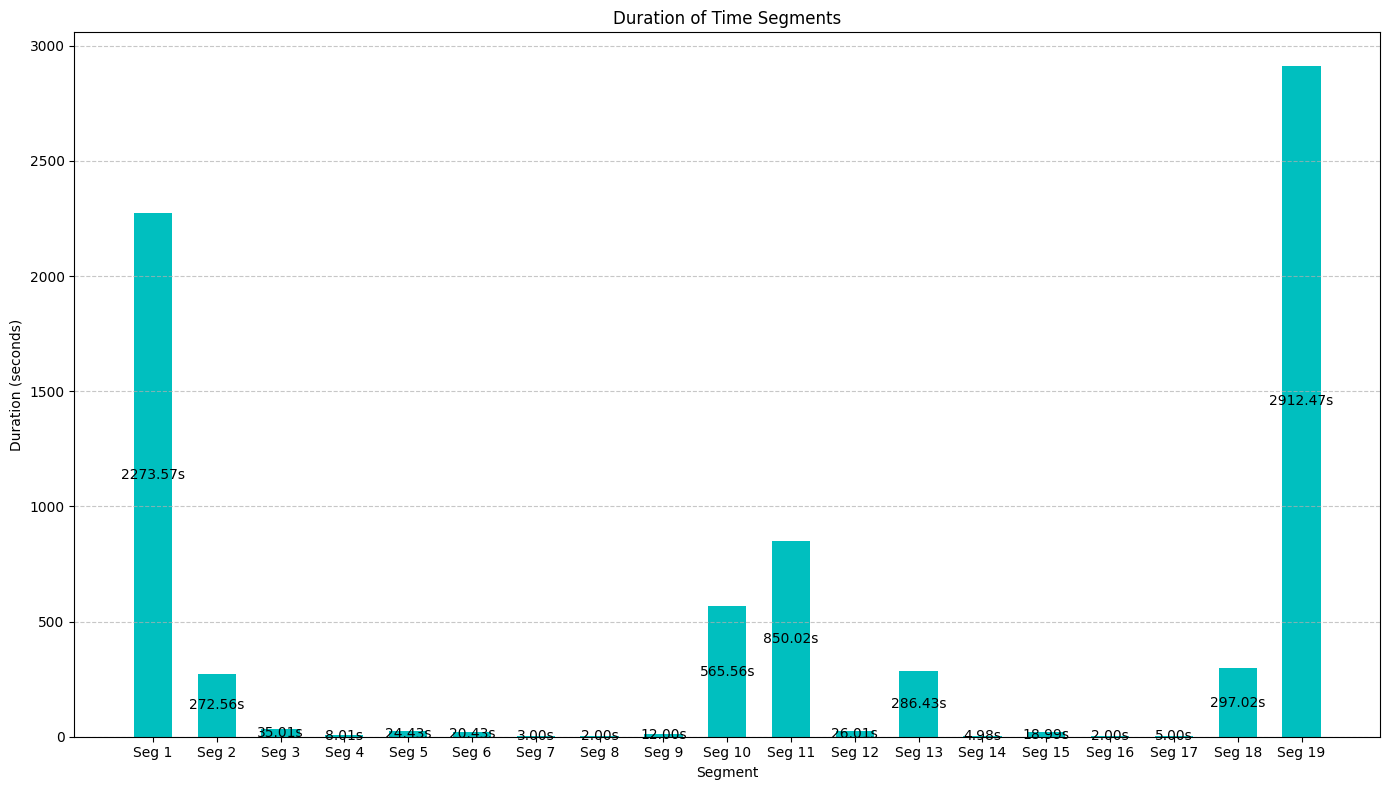

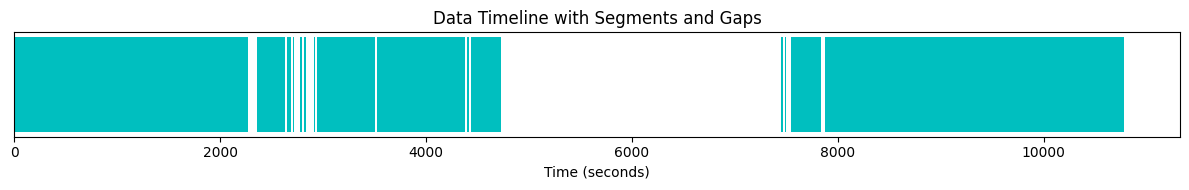

In [16]:
file_path = './Synched_Data_GR0_22_DEN_MAXZ1_25/NEWDATA/'
date = '101922'
file_name = f'DAYUBIGR_{date}_GR0_22_DEN_032825_V2392628911.CSV'
full_path = file_path + file_name
raw_data = pd.read_csv(full_path, header=None, names=['SUBJECTID', 'TIME', 'X', 'Y', 'Z'])
clear_data = raw_data.reset_index(drop=True)
clear_data = clear_data[(clear_data["X"] <= 15) & (clear_data["Y"] <= 9) & 
                        (clear_data["X"] >= 0) & (clear_data["Y"] >= 0)].copy()
target_subject_base = "DS_STARFISH_2223_27"
subject_data = clear_data[clear_data['SUBJECTID'].str.startswith(target_subject_base)].copy()

subject_data['TIME'] = pd.to_datetime(subject_data['TIME'])
t0 = subject_data['TIME'].min()
subject_data['timestamp'] = (subject_data['TIME'] - t0).dt.total_seconds()
subject_data['side'] = subject_data['SUBJECTID'].str.extract(r'(\d+[LR])$')[0].str[-1].map({'L': 'left', 'R': 'right'})

df = pd.DataFrame(real_data)
df = df.sort_values('timestamp')
df['time_diff'] = df['timestamp'].diff()

gap_threshold = 15.0
gaps = df[df['time_diff'] > gap_threshold]

segments = []
current_segment_start = df['timestamp'].iloc[0]

for idx, row in gaps.iterrows():
    segment_end = row['timestamp'] - row['time_diff']
    
    # Count data points in this segment
    segment_data = df[(df['timestamp'] >= current_segment_start) & 
                      (df['timestamp'] <= segment_end)]
    num_points = len(segment_data)
    
    segments.append({
        'start': current_segment_start,
        'end': segment_end,
        'duration': segment_end - current_segment_start,
        'num_points': num_points
    })
    
    current_segment_start = row['timestamp']

# Add the last segment (with data point count)
segment_data = df[(df['timestamp'] >= current_segment_start) & 
                  (df['timestamp'] <= df['timestamp'].iloc[-1])]
num_points = len(segment_data)

segments.append({
    'start': current_segment_start,
    'end': df['timestamp'].iloc[-1],
    'duration': df['timestamp'].iloc[-1] - current_segment_start,
    'num_points': num_points  # <-- New field: number of data points
})

# Convert to DataFrame for better visualization
segments_df = pd.DataFrame(segments)

# Print segment info (now includes point counts)
print("\nTime Segments Information:")
for i, segment in enumerate(segments):
    print(
        f"Segment {i+1}: "
        f"{segment['start']:.2f}s - {segment['end']:.2f}s | "
        f"Duration: {segment['duration']:.2f}s | "
        f"Points: {segment['num_points']}"
    )

# Time segments
plt.figure(figsize=(14, 8))
plt.bar(
    range(len(segments)), 
    segments_df['duration'],
    width=0.6,
    color='c'
)

plt.xticks(range(len(segments)), [f"Seg {i+1}" for i in range(len(segments))])
plt.xlabel('Segment')
plt.ylabel('Duration (seconds)')
plt.title(f'Duration of Time Segments')
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, duration in enumerate(segments_df['duration']):
    plt.text(i, duration/2, f"{duration:.2f}s", ha='center', va='center', color='black')

plt.tight_layout()
plt.savefig(f'segment_durations_{target_subject_base}_{date}.png')
plt.show()

# Time gaps
plt.figure(figsize=(12, 2))
timeline_y = 1
timeline_height = 0.3

total_time = df['timestamp'].iloc[-1] - df['timestamp'].iloc[0]
plt.barh(timeline_y, total_time, height=timeline_height, left=df['timestamp'].iloc[0], color='white')

# Plot each segment
for segment in segments:
    plt.barh(
        timeline_y, 
        segment['duration'], 
        height=timeline_height, 
        left=segment['start'], 
        color='c'
    )

plt.xlabel('Time (seconds)')
plt.yticks([])
plt.title(f'Data Timeline with Segments and Gaps')
plt.tight_layout()
plt.savefig(f'timeline_{target_subject_base}_{date}.png')
plt.show()

# Store the segments
time_segments = []
for segment in segments:
    segment_data = df[(df['timestamp'] >= segment['start']) & 
                      (df['timestamp'] <= segment['end'])].copy()
    time_segments.append({
        'start': segment['start'],
        'end': segment['end'],
        'duration': segment['duration'],
        'data': segment_data
    })


In [17]:
for i, segment in enumerate(time_segments):
    if 'data' in segment:
        nan_count = segment['data'].isna().sum().sum()  # Total NaN counts in the DataFrame
        if nan_count > 0:
            print(f"Segment {i} has {nan_count} NaN values in its data.")
            print(segment['data'].isna().sum())  # Show NaN counts per column

Segment 0 has 3672 NaN values in its data.
timestamp       0
left         1762
observed        0
obs             0
right        1909
time_diff       1
dtype: int64
Segment 1 has 390 NaN values in its data.
timestamp      0
left         144
observed       0
obs            0
right        246
time_diff      0
dtype: int64
Segment 2 has 38 NaN values in its data.
timestamp     0
left          2
observed      0
obs           0
right        36
time_diff     0
dtype: int64
Segment 3 has 9 NaN values in its data.
timestamp    0
left         0
observed     0
obs          0
right        9
time_diff    0
dtype: int64
Segment 4 has 28 NaN values in its data.
timestamp     0
left         10
observed      0
obs           0
right        18
time_diff     0
dtype: int64
Segment 5 has 16 NaN values in its data.
timestamp     0
left         11
observed      0
obs           0
right         5
time_diff     0
dtype: int64
Segment 6 has 4 NaN values in its data.
timestamp    0
left         4
observed     0
o

In [63]:
def visualize_results_new(data, s_smooth, virtual_timestamps, master_timestamps):
    plt.figure(figsize=(12, 8))
    
    left_x, left_y = [], []
    right_x, right_y = [], []
    
    for entry in data:
        # Skip if 'left' is not a list or has wrong length
        if 'left' in entry and isinstance(entry['left'], (list, np.ndarray)) and len(entry['left']) >= 2:
            left_x.append(entry['left'][0])
            left_y.append(entry['left'][1])
        
        # Skip if 'right' is not a list or has wrong length
        if 'right' in entry and isinstance(entry['right'], (list, np.ndarray)) and len(entry['right']) >= 2:
            right_x.append(entry['right'][0])
            right_y.append(entry['right'][1])
    
    plt.scatter(left_x, left_y, color='blue', alpha=0.3, label='Left Sensor')
    plt.scatter(right_x, right_y, color='red', alpha=0.3, label='Right Sensor')
    plt.title('initial parameters: 0.01 0.01 0.5')
    
    # Smoothed trajectory
    plt.plot([s[0] for s in s_smooth], [s[1] for s in s_smooth], 'g-', alpha=0.7, linewidth=2, label='Smoothed Trajectory')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Optimized parameters (sigma_vx, sigma_vy, sigma_omega, sigma_obs, d): [0.49943293 0.50034073 0.09195618 0.42774451 0.24155054]
Negative log-likelihood: 5945.851584048384


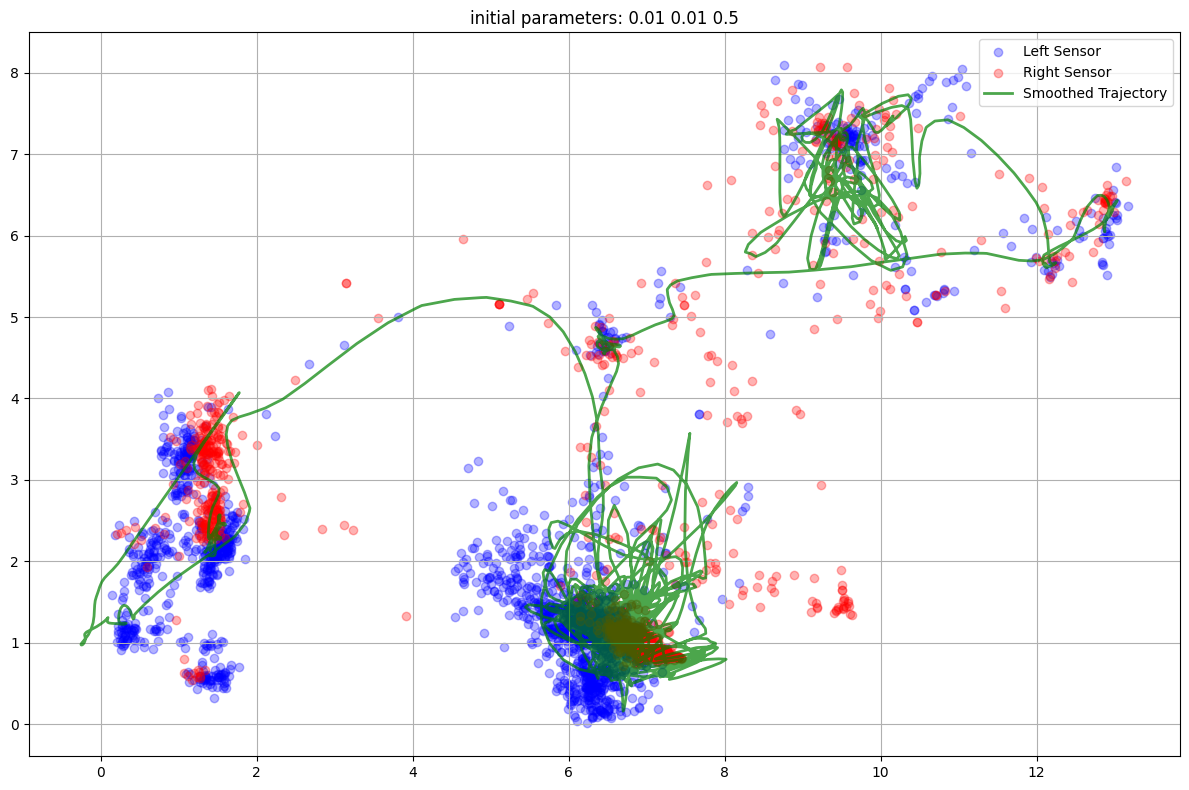

In [68]:
if __name__ == "__main__":

    data = time_segments[0]['data'].to_dict(orient='records')
    s_smooth, P_smooth, optimized_params, virtual_timestamps = process_trajectory(data)
    timestamps = [entry['timestamp'] for entry in data]
    master_timestamps = sorted(set(timestamps + virtual_timestamps))
    visualize_results_new(data, s_smooth, virtual_timestamps, master_timestamps)

## Visualize Uncertainty

In [ ]:
def plot_uncertainty_ellipses(timestamps, states, covariances, confidence_levels=[0.68, 0.95], title="Position Uncertainty Over Time", figsize=(14, 10)):
    fig, ax = plt.subplots(figsize=figsize)
    
    x_pos = [state[0] for state in states]
    y_pos = [state[1] for state in states]
    ax.plot(x_pos, y_pos, 'g-', linewidth=2, alpha=0.7, label='Estimated Trajectory')

    step = max(1, len(timestamps) // 20)  # Show ~20 ellipses maximum
    
    for i in range(0, len(timestamps), step):
        # covariance (2x2 submatrix)
        pos_cov = covariances[i][:2, :2]
        
        # Compute eigenvalues and eigenvectors
        eigenvals, eigenvecs = np.linalg.eigh(pos_cov)
        
        # Sort by eigenvalue
        order = eigenvals.argsort()[::-1]
        eigenvals = eigenvals[order]
        eigenvecs = eigenvecs[:, order]
        
        # Calculate angle of major axis
        angle = np.degrees(np.arctan2(eigenvecs[1, 0], eigenvecs[0, 0]))
        
        # Plot ellipses for different confidence levels
        colors = ['lightblue', 'lightcoral', 'lightgreen']
        for j, conf_level in enumerate(confidence_levels):
            # Chi-square critical value for 2 DOF
            chi2_val = chi2.ppf(conf_level, df=2)
            
            # Calculate ellipse dimensions
            width = 2 * np.sqrt(chi2_val * eigenvals[0])
            height = 2 * np.sqrt(chi2_val * eigenvals[1])
            
            ellipse = Ellipse(xy=(x_pos[i], y_pos[i]), 
                            width=width, height=height, 
                            angle=angle, 
                            facecolor=colors[j % len(colors)], 
                            alpha=0.3, 
                            edgecolor='black', 
                            linewidth=0.5)
            ax.add_patch(ellipse)
    
    for j, conf_level in enumerate(confidence_levels):
        ax.scatter([], [], color=colors[j % len(colors)], alpha=0.3, s=100, label=f'{conf_level*100:.0f}% Confidence')
    
    ax.set_xlabel('X Position')
    ax.set_ylabel('Y Position')
    ax.set_title(title)
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal')
    
    plt.tight_layout()
    return fig, ax

def visualize_smoothed_uncertainty(real_data, s_smooth, P_smooth, max_data_points=3000):

    if max_data_points:
        real_data = real_data[:max_data_points]
        s_smooth = s_smooth[:max_data_points] if len(s_smooth) > max_data_points else s_smooth
        P_smooth = P_smooth[:max_data_points] if len(P_smooth) > max_data_points else P_smooth
    
    timestamps = [entry['timestamp'] for entry in real_data]
    fig1, _ = plot_uncertainty_ellipses(timestamps, s_smooth, P_smooth, title="Smoothed Position Uncertainty Ellipses")
    plt.show()
    
    return fig1

In [ ]:
def plot_sigma_statistics(timestamps, covariances, title="Sigma Statistics Over Time", figsize=(14, 8)):
    fig, axes = plt.subplots(2, 2, figsize=figsize)

    min_length = min(len(timestamps), len(covariances)) #####!!!!
    timestamps = timestamps[:min_length]
    covariances = covariances[:min_length]
    
    sigma_means = []
    sigma_mins = []
    sigma_maxs = []
    sigma_stds = []
    
    for cov in covariances:
        sigmas = [np.sqrt(cov[i, i]) for i in range(6)]
        sigma_means.append(np.mean(sigmas))
        sigma_mins.append(np.min(sigmas))
        sigma_maxs.append(np.max(sigmas))
        sigma_stds.append(np.std(sigmas))
    
    axes[0, 0].plot(timestamps, sigma_means, 'b-', linewidth=2)
    axes[0, 0].set_title('Mean of All Sigmas')
    axes[0, 0].set_ylabel('Mean Sigma')
    axes[0, 0].grid(True, alpha=0.3)
    
    axes[0, 1].plot(timestamps, sigma_mins, 'g-', linewidth=2, label='Min')
    axes[0, 1].plot(timestamps, sigma_maxs, 'r-', linewidth=2, label='Max')
    axes[0, 1].set_title('Min/Max of All Sigmas')
    axes[0, 1].set_ylabel('Sigma Value')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    axes[1, 0].plot(timestamps, sigma_stds, 'purple', linewidth=2)
    axes[1, 0].set_title('Standard Deviation of All Sigmas')
    axes[1, 0].set_xlabel('Time (s)')
    axes[1, 0].set_ylabel('Std of Sigmas')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Range plot
    axes[1, 1].fill_between(timestamps, sigma_mins, sigma_maxs, alpha=0.3, color='lightblue')
    axes[1, 1].plot(timestamps, sigma_means, 'b-', linewidth=2, label='Mean')
    axes[1, 1].set_title('Sigma Range Over Time')
    axes[1, 1].set_xlabel('Time (s)')
    axes[1, 1].set_ylabel('Sigma Value')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    return fig, axes

In [ ]:
def optimize_parameters_with_tracking(data, timestamps, virtual_timestamps, initial_params=None):
    global param_history, iteration_count
    
    # Reset tracking variables
    param_history = defaultdict(list)
    iteration_count = 0
    
    if initial_params is None:
        initial_params = [0.5, 0.5, 0.1, 0.5, 0.23]
    
    SIGMA_MIN = 0.000001
    SIGMA_MAX = 10
    
    bounds = [
        (SIGMA_MIN, SIGMA_MAX),  # sigma_vx
        (SIGMA_MIN, SIGMA_MAX),  # sigma_vy
        (SIGMA_MIN, SIGMA_MAX),  # sigma_omega
        (SIGMA_MIN, SIGMA_MAX),  # sigma_obs
        (0.01, 1.0)              # d
    ]
    
    def objective(params):
        track_parameters(params)  # Track parameters at each iteration
        try:
            _, _, _, _, neg_log_likelihood = ekf_forward(data, timestamps, virtual_timestamps, params)
            return neg_log_likelihood
        except Exception as e:
            print(f"Error in objective function: {e}")
            return 1e10
    
    result = minimize(
        objective,
        initial_params,
        method='Nelder-Mead',
        bounds=bounds,
        options={'disp': True, 'maxiter': 100}
    )
    
    return result.x, param_history

def plot_sigma_evolution(param_history):
    df = pd.DataFrame(param_history)

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle('Evolution of Parameters During Optimization', fontsize=16, fontweight='bold')
    
    # Individual parameter plots
    params_info = [
        ('sigma_vx', 'Sigma VX (Velocity X Noise)', 'blue'),
        ('sigma_vy', 'Sigma VY (Velocity Y Noise)', 'red'),
        ('sigma_omega', 'Sigma Omega (Angular Velocity Noise)', 'green'),
        ('sigma_obs', 'Sigma Obs (Observation Noise)', 'orange'),
        ('d', 'Distance Between Sensors', 'purple')
    ]
    
    for i, (param, title, color) in enumerate(params_info):
        row = i // 3
        col = i % 3
        ax = axes[row, col]
        
        ax.plot(df['iteration'], df[param], color=color, linewidth=2, marker='o', markersize=3)
        ax.set_title(title, fontweight='bold')
        ax.set_xlabel('Iteration')
        ax.set_ylabel('Parameter Value')
        ax.grid(True, alpha=0.3)
        ax.set_yscale('log')  # Log scale for better visualization of sigma values
    
    # Combined sigma plot
    ax_combined = axes[1, 2]
    ax_combined.plot(df['iteration'], df['sigma_vx'], label='σ_vx', linewidth=2, marker='o', markersize=2)
    ax_combined.plot(df['iteration'], df['sigma_vy'], label='σ_vy', linewidth=2, marker='s', markersize=2)
    ax_combined.plot(df['iteration'], df['sigma_omega'], label='σ_ω', linewidth=2, marker='^', markersize=2)
    ax_combined.plot(df['iteration'], df['sigma_obs'], label='σ_obs', linewidth=2, marker='d', markersize=2)
    
    ax_combined.set_title('All Sigma Parameters', fontweight='bold')
    ax_combined.set_xlabel('Iteration')
    ax_combined.set_ylabel('Parameter Value')
    ax_combined.set_yscale('log')
    ax_combined.grid(True, alpha=0.3)
    ax_combined.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Create a summary table
    print("\n" + "="*60)
    print("PARAMETER EVOLUTION SUMMARY")
    print("="*60)
    print(f"{'Parameter':<15} {'Initial':<12} {'Final':<12} {'Change %':<12}")
    print("-"*60)
    
    for param in ['sigma_vx', 'sigma_vy', 'sigma_omega', 'sigma_obs', 'd']:
        initial = df[param].iloc[0]
        final = df[param].iloc[-1]
        change_pct = ((final - initial) / initial) * 100
        print(f"{param:<15} {initial:<12.6f} {final:<12.6f} {change_pct:<12.2f}")
    
    return df

def analyze_convergence(param_history, window_size=5):
    """Analyze convergence characteristics of the optimization"""
    df = pd.DataFrame(param_history)
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    fig.suptitle('Convergence Analysis', fontsize=16, fontweight='bold')
    
    # Parameter change rates
    ax1 = axes[0, 0]
    for param in ['sigma_vx', 'sigma_vy', 'sigma_omega', 'sigma_obs']:
        changes = np.abs(np.diff(df[param]))
        smoothed_changes = pd.Series(changes).rolling(window=window_size, min_periods=1).mean()
        ax1.plot(smoothed_changes, label=param, linewidth=2)
    
    ax1.set_title('Parameter Change Rates (Smoothed)')
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Absolute Change')
    ax1.set_yscale('log')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Relative parameter changes
    ax2 = axes[0, 1]
    for param in ['sigma_vx', 'sigma_vy', 'sigma_omega', 'sigma_obs']:
        rel_changes = np.abs(np.diff(df[param]) / df[param].iloc[:-1]) * 100
        smoothed_rel_changes = pd.Series(rel_changes).rolling(window=window_size, min_periods=1).mean()
        ax2.plot(smoothed_rel_changes, label=param, linewidth=2)
    
    ax2.set_title('Relative Parameter Changes (%)')
    ax2.set_xlabel('Iteration')
    ax2.set_ylabel('Relative Change (%)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Parameter ratios over time
    ax3 = axes[1, 0]
    ax3.plot(df['sigma_vx'] / df['sigma_vy'], label='σ_vx / σ_vy', linewidth=2)
    ax3.plot(df['sigma_obs'] / df['sigma_vx'], label='σ_obs / σ_vx', linewidth=2)
    ax3.plot(df['sigma_omega'] * 10, label='σ_ω × 10', linewidth=2)  # Scale for visibility
    
    ax3.set_title('Parameter Ratios')
    ax3.set_xlabel('Iteration')
    ax3.set_ylabel('Ratio Value')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Convergence indicator
    ax4 = axes[1, 1]
    total_change = sum(np.abs(np.diff(df[param])) for param in ['sigma_vx', 'sigma_vy', 'sigma_omega', 'sigma_obs'])
    smoothed_total_change = pd.Series(total_change).rolling(window=window_size, min_periods=1).mean()
    ax4.plot(smoothed_total_change, color='red', linewidth=3)
    ax4.set_title('Overall Convergence Indicator')
    ax4.set_xlabel('Iteration')
    ax4.set_ylabel('Total Parameter Change')
    ax4.set_yscale('log')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def run_sigma_analysis(real_data, max_data_points=1000):    
    # Prepare data
    limited_data = real_data[:max_data_points]
    timestamps = [entry['timestamp'] for entry in limited_data]
    
    # Create virtual timestamps
    DT_VIRT = 0.5
    virtual_timestamps = []
    if timestamps:
        t_min, t_max = min(timestamps), max(timestamps)
        t = t_min
        while t <= t_max:
            if t not in timestamps:
                virtual_timestamps.append(t)
            t += DT_VIRT
    
    print(f"Using {len(limited_data)} data points")
    print(f"Time range: {min(timestamps):.2f} to {max(timestamps):.2f} seconds")
    
    # Run optimization with parameter tracking
    optimized_params, param_history = optimize_parameters_with_tracking(
        limited_data, timestamps, virtual_timestamps
    )
    
    print(f"\nOptimization completed after {len(param_history['iteration'])} iterations")
    print(f"Final parameters: {optimized_params}")
    
    # Create visualizations
    param_df = plot_sigma_evolution(param_history)
    analyze_convergence(param_history)
    
    return optimized_params, param_history, param_df

Optimized parameters (sigma_vx, sigma_vy, sigma_omega, sigma_obs, d): [0.49943293 0.50034073 0.09195618 0.42774451 0.24155054]
Negative log-likelihood: 5945.851584048384


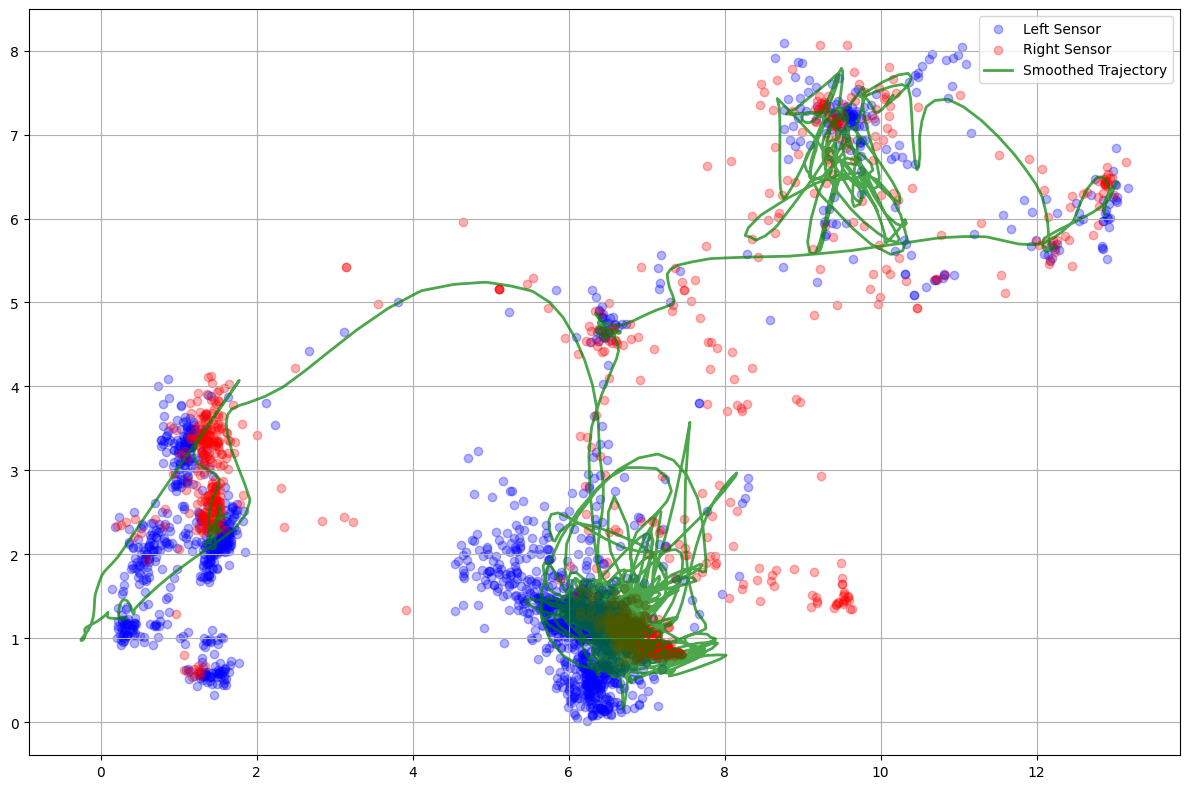

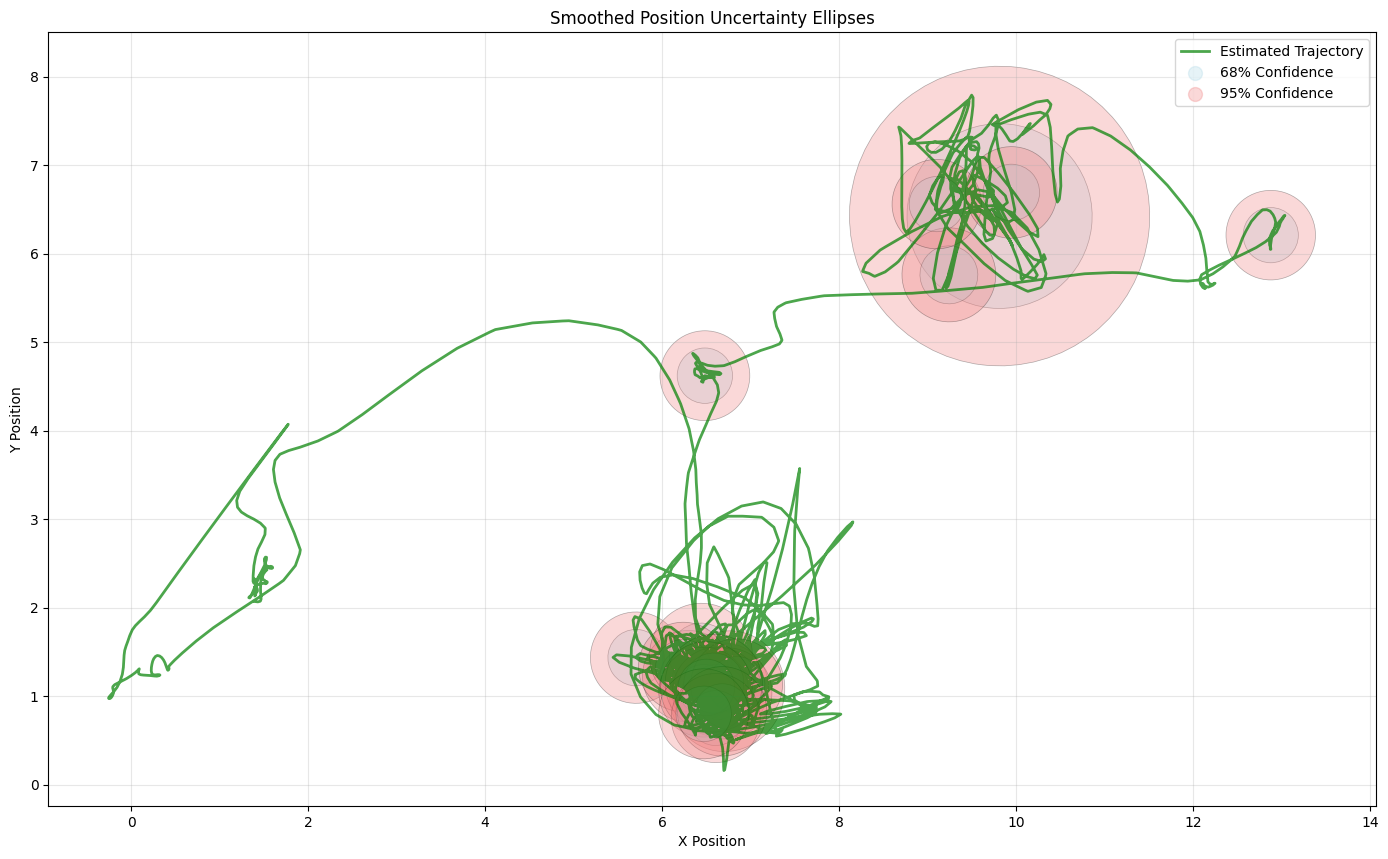

Starting parameter optimization with tracking...
Using 3671 data points
Time range: 0.00 to 2273.57 seconds


NameError: name 'optimize_parameters_with_tracking' is not defined

In [ ]:
if __name__ == "__main__":
    data = time_segments[0]['data'].to_dict(orient='records')
    s_smooth, P_smooth, optimized_params, virtual_timestamps = process_trajectory(data)
    timestamps = [entry['timestamp'] for entry in data]
    master_timestamps = sorted(set(timestamps + virtual_timestamps))

    visualize_results_new(data, s_smooth, virtual_timestamps, master_timestamps)
    visualize_smoothed_uncertainty(data, s_smooth, P_smooth, max_data_points)
    # fig, _ = plot_sigma_statistics(timestamps, P_smooth, "Smoothed Sigma Statistics")
    plt.show()

Starting parameter optimization with tracking...
Using 3671 data points
Time range: 0.00 to 2273.57 seconds


/var/folders/p3/w6bdbvgx3qg4dgmll4zcxg_r0000gn/T/ipykernel_42377/2730455399.py:31: RuntimeWarning: Maximum number of iterations has been exceeded.
  result = minimize(



Optimization completed after 272 iterations
Final parameters: [0.51749942 0.48749925 0.10099998 0.50500167 0.23229903]


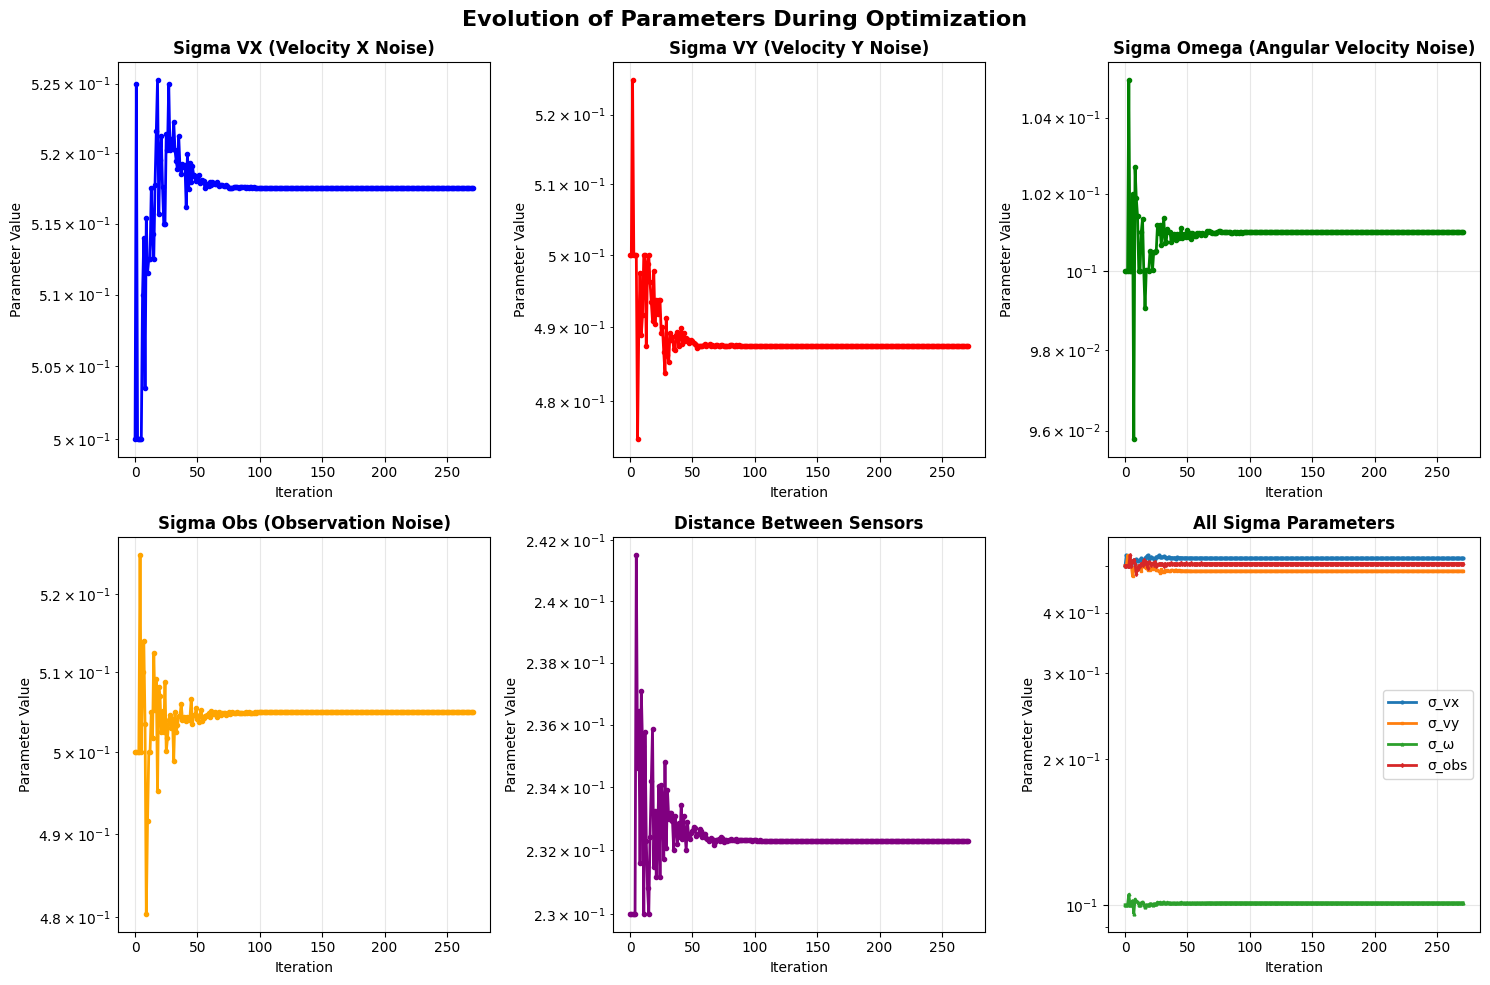


PARAMETER EVOLUTION SUMMARY
Parameter       Initial      Final        Change %    
------------------------------------------------------------
sigma_vx        0.500000     0.517499     3.50        
sigma_vy        0.500000     0.487499     -2.50       
sigma_omega     0.100000     0.101000     1.00        
sigma_obs       0.500000     0.505002     1.00        
d               0.230000     0.232299     1.00        


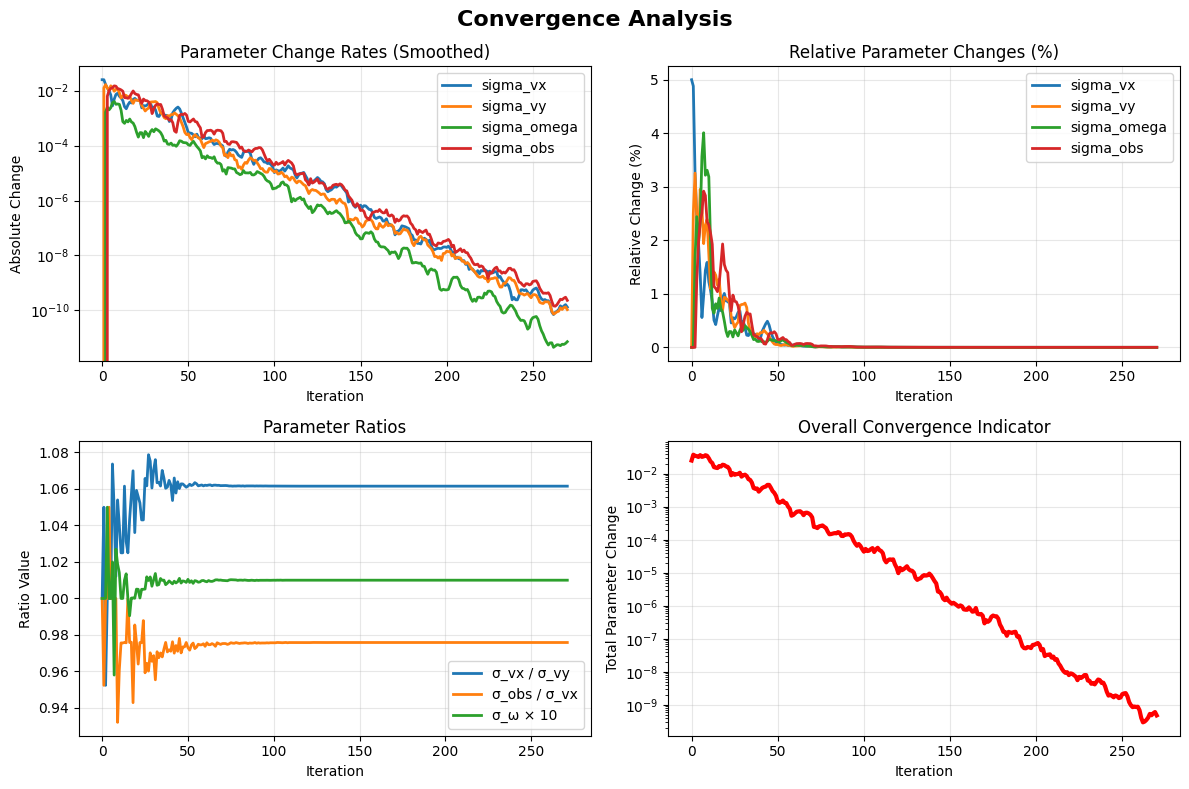

In [40]:
if __name__ == "__main__":
    data = time_segments[0]['data'].to_dict(orient='records')
    timestamps = [entry['timestamp'] for entry in data]
    master_timestamps = sorted(set(timestamps + virtual_timestamps))

    run_sigma_analysis(data, 4000)
    plt.show()